Projeto de Transfer Learning

In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

BASE DE DADOS ISIC

In [2]:
!pip install isic-cli

# Criar diretórios
!mkdir -p ISIC/Malignant/SCC_NOS
!mkdir -p ISIC/Benign/PBK

# Baixar Malignant → SCC_NOS
!isic image download --search 'diagnosis_3:"Squamous cell carcinoma, NOS"' ISIC/Malignant/SCC_NOS

# Baixar Benign → Pigmented benign keratosis
!isic image download --search 'diagnosis_3:"Pigmented benign keratosis"' ISIC/Benign/PBK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
If you have been granted special permissions, logging in with `isic user login` might return more data.


Successfully downloaded 1,717 images to ISIC/Malignant/SCC_NOS/.
Successfully wrote 1,717 metadata records to ISIC/Malignant/SCC_NOS/metadata.csv.
Successfully wrote attributions to ISIC/Malignant/SCC_NOS/attribution.txt.
Successfully wrote 3 license(s) to ISIC/Malignant/SCC_NOS/licenses.
If you have been granted special permissions, logging in with `isic user login` might return more data.


Successfully downloaded 1,341 images to ISIC/Benign/PBK/.
Successfully wrote 1,341 metadata records to ISIC/Benign/PBK/metadata.csv.
Successfully wrote attributions to ISIC/Benign/PBK/attribution.txt.
Successfully wrote 2 license(s) to ISIC/Benign/PBK/licenses.


In [3]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [4]:
import os
import numpy as np

# Definir categorias
categories = [
    "ISIC/Malignant/SCC_NOS",
    "ISIC/Benign/PBK"
]

data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)   # precisa estar definida sua função get_image
        data.append({'x':np.array(x[0]), 'y':c})

# número de classes
num_classes = len(categories)
print("Número de classes:", num_classes)

Número de classes: 2


In [5]:
random.shuffle(data)

CRIAÇÃO DE TREINO / VALIDAÇÃO / TESTE (70%, 15%, 15%)

In [6]:
# proporções
train_split = 0.7
val_split = 0.15

# dividir dataset
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))

train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

print(f"Tamanho do treino: {len(train)}")
print(f"Tamanho da validação: {len(val)}")
print(f"Tamanho do teste: {len(test)}")


Tamanho do treino: 2140
Tamanho da validação: 459
Tamanho do teste: 459


In [7]:
x_train = np.array([t["x"] for t in train])
y_train = np.array([t["y"] for t in train])

x_val = np.array([t["x"] for t in val])
y_val = np.array([t["y"] for t in val])

x_test = np.array([t["x"] for t in test])
y_test = np.array([t["y"] for t in test])

print("Shape do x_train:", x_train.shape)
print("Shape do y_train:", y_train.shape)
print("Shape do x_val:", x_val.shape)
print("Shape do y_val:", y_val.shape)
print("Shape do x_test:", x_test.shape)
print("Shape do y_test:", y_test.shape)
print("y_test:", y_test)

Shape do x_train: (2140, 224, 224, 3)
Shape do y_train: (2140,)
Shape do x_val: (459, 224, 224, 3)
Shape do y_val: (459,)
Shape do x_test: (459, 224, 224, 3)
Shape do y_test: (459,)
y_test: [0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1
 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0
 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0
 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1
 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0
 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0
 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1
 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1
 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0
 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0
 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0

In [8]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(459, 2)


In [9]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 3058 images from 2 categories
train / validation / test split: 2140, 459, 459
training data shape:  (2140, 224, 224, 3)
training labels shape:  (2140, 2)


Total de imagens encontradas: 3058


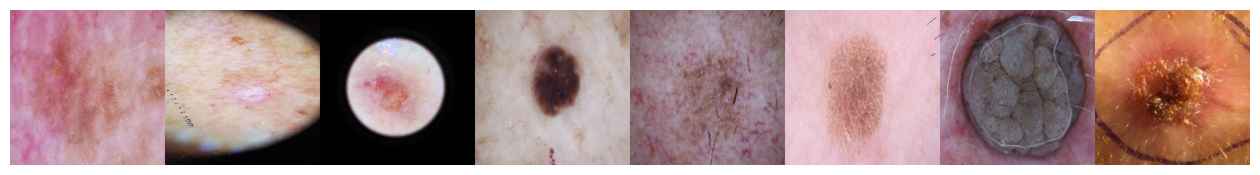

In [10]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Defina a raiz onde estão suas imagens
root = "ISIC"  # pode ser "ISIC/Malignant/SCC_NOS" se quiser só uma classe

# Listar todas as imagens
images = [os.path.join(dp, f)
          for dp, dn, filenames in os.walk(root)
          for f in filenames
          if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]

print(f"Total de imagens encontradas: {len(images)}")

# Sortear 8 imagens aleatórias
idx = random.sample(range(len(images)), 8)
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]

# Converter todas para arrays (garantir mesmo shape e 3 canais RGB)
imgs_array = [np.asarray(img.convert("RGB")) for img in imgs]

# Concatenar horizontalmente
concat_image = np.concatenate(imgs_array, axis=1)

# Mostrar
plt.figure(figsize=(16, 4))
plt.imshow(concat_image)
plt.axis("off")
plt.show()

In [11]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 144s 8s/step - accuracy: 0.5595 - loss: 0.6849 - val_accuracy: 0.7821 - val_loss: 0.4924
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 196s 8s/step - accuracy: 0.7748 - loss: 0.4955 - val_accuracy: 0.7734 - val_loss: 0.5010
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 145s 8s/step - accuracy: 0.7891 - loss: 0.4704 - val_accuracy: 0.7712 - val_loss: 0.4842
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 146s 8s/step - accuracy: 0.7868 - loss: 0.4428 - val_accuracy: 0.8105 - val_loss: 0.4064
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 198s 8s/step - accuracy: 0.8152 - loss: 0.3929 - val_accuracy: 0.8235 - val_loss: 0.3968
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 140s 8s/step - accuracy: 0.8273 - loss: 0.3758 - val_accuracy: 0.8105 - val_loss: 0.3938
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 144s 8s/step - accuracy: 0.8336 - loss: 0.3799 - val_accuracy: 0.8126 - val_loss: 0.3891
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 148s 9s/step - accuracy: 0.8265 - loss: 0.3719 - val_accuracy: 0.8148 - v

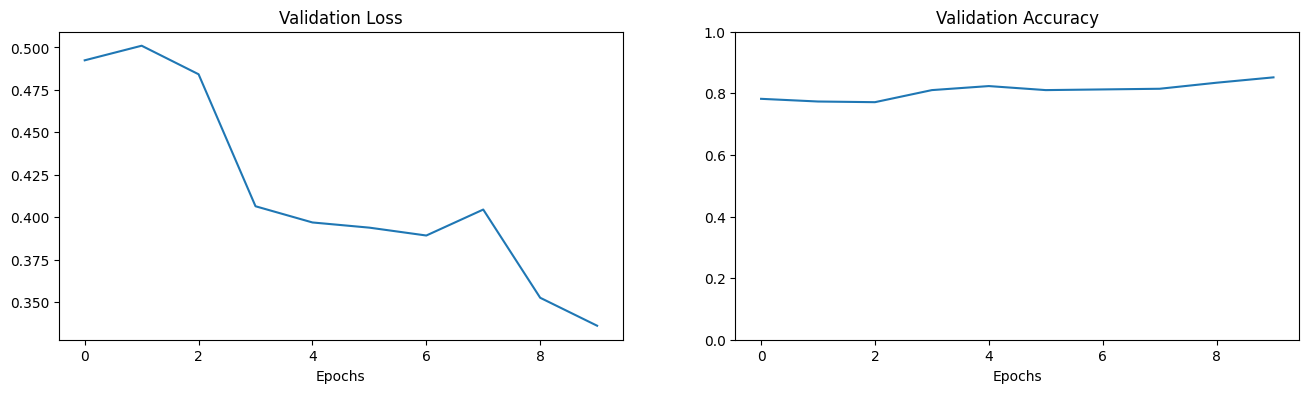

In [13]:
fig = plt.figure(figsize=(16,4))

ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("Validation Loss")
ax.set_xlabel("Epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylim(0, 1)

plt.show()

In [14]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.30965790152549744
Test accuracy: 0.8453159332275391


TRANSFER LEARNING COMEÇANDO COM NETWORK JÁ EXISTENTE

In [15]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [17]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [18]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1402s 83s/step - accuracy: 0.5175 - loss: 0.9300 - val_accuracy: 0.6078 - val_loss: 0.6341
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1414s 84s/step - accuracy: 0.5942 - loss: 0.6684 - val_accuracy: 0.6732 - val_loss: 0.6017
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1446s 83s/step - accuracy: 0.6770 - loss: 0.6034 - val_accuracy: 0.6754 - val_loss: 0.5893
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1391s 82s/step - accuracy: 0.6957 - loss: 0.5785 - val_accuracy: 0.6558 - val_loss: 0.6035
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1378s 81s/step - accuracy: 0.6890 - loss: 0.5744 - val_accuracy: 0.6580 - val_loss: 0.6033
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1395s 80s/step - accuracy: 0.6850 - loss: 0.5638 - val_accuracy: 0.7124 - val_loss: 0.5605
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1427s 82s/step - accuracy: 0.7092 - loss: 0.5513 - val_accuracy: 0.6558 - val_loss: 0.6274
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1407s 82s/step - accuracy: 0.6825 - loss: 0.5675 - val_accu

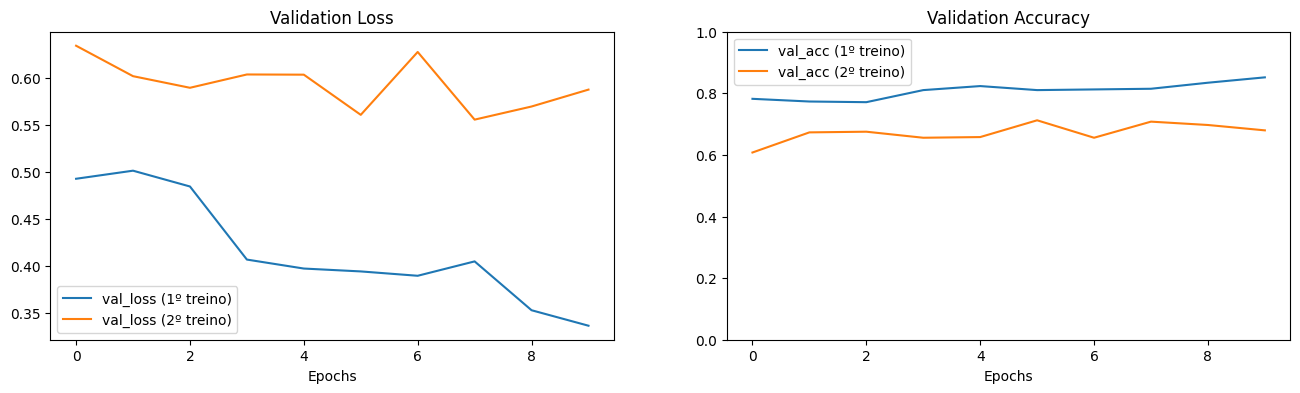

In [20]:
fig = plt.figure(figsize=(16,4))

# Loss
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"], label="val_loss (1º treino)")
ax.plot(history2.history["val_loss"], label="val_loss (2º treino)")
ax.set_title("Validation Loss")
ax.set_xlabel("Epochs")
ax.legend()

# Accuracy
ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"], label="val_acc (1º treino)")
ax2.plot(history2.history["val_accuracy"], label="val_acc (2º treino)")
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylim(0, 1)
ax2.legend()

plt.show()


In [21]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.5851598381996155
Test accuracy: 0.6928104758262634


In [12]:
!pip install isic-cli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00


In [13]:
!isic image download --search 'diagnosis_3:"Squamous cell carcinoma, NOS"' ISIC/Malignant/SCC_NOS
!isic image download --search 'diagnosis_3:"Pigmented benign keratosis"' ISIC/Benign/PBK

If you have been granted special permissions, logging in with `isic user login` might return more data.


Successfully downloaded 1,717 images to ISIC/Malignant/SCC_NOS/.
Successfully wrote 1,717 metadata records to ISIC/Malignant/SCC_NOS/metadata.csv.
Successfully wrote attributions to ISIC/Malignant/SCC_NOS/attribution.txt.
Successfully wrote 3 license(s) to ISIC/Malignant/SCC_NOS/licenses.
If you have been granted special permissions, logging in with `isic user login` might return more data.


Successfully downloaded 1,341 images to ISIC/Benign/PBK/.
Successfully wrote 1,341 metadata records to ISIC/Benign/PBK/metadata.csv.
Successfully wrote attributions to ISIC/Benign/PBK/attribution.txt.
Successfully wrote 2 license(s) to ISIC/Benign/PBK/licenses.


In [14]:
malignant_file = random.choice(os.listdir("ISIC/Malignant/SCC_NOS"))
benign_file = random.choice(os.listdir("ISIC/Benign/PBK"))


In [16]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Lista das categorias e pastas
categories = ["Malignant", "Benign"]
folders = {
    "Malignant": "ISIC/Malignant/SCC_NOS",
    "Benign": "ISIC/Benign/PBK"
}

# Função para carregar e preprocessar uma imagem
def load_isic_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # normalização
    return img, x

# Função para escolher imagem aleatória e predizer
def predict_random_image(model):
    for cat in categories:
        folder = folders[cat]
        if len(os.listdir(folder)) == 0:
            print(f"Nenhuma imagem encontrada em {folder}")
            continue

        # Escolher uma imagem aleatória
        img_file = random.choice(os.listdir(folder))
        img_path = os.path.join(folder, img_file)

        # Carregar imagem
        img, x = load_isic_image(img_path)

        # Predição
        pred = model.predict(x)
        pred_class = categories[np.argmax(pred)]

        # Mostrar
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Arquivo: {img_file}\nClasse predita: {pred_class}")
        plt.show()


In [18]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Base pré-treinada
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Congelar camadas da base
for layer in base_model.layers:
    layer.trainable = False

# Adicionar camadas finais
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation="relu")(x)
output = Dense(2, activation="softmax")(x)  # 2 classes: Malignant e Benign

model_new = Model(inputs=base_model.input, outputs=output)

# Compilar modelo
model_new.compile(optimizer=Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


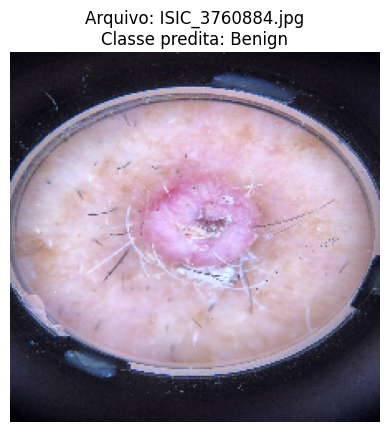

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


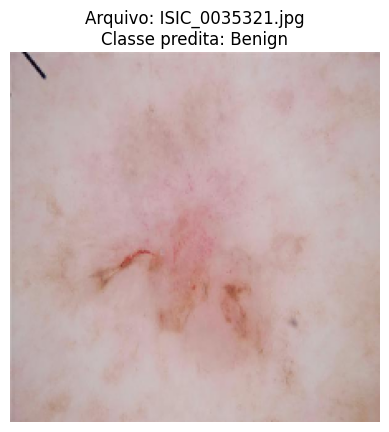

In [24]:
predict_random_image(model_new)


In [25]:
import os

malignant_folder = "ISIC/Malignant/SCC_NOS"
print("Arquivos Malignant:", os.listdir(malignant_folder)[:10])


Arquivos Malignant: ['ISIC_7841432.jpg', 'ISIC_0027178.jpg', 'ISIC_0055107.jpg', 'ISIC_5535209.jpg', 'ISIC_0031431.jpg', 'ISIC_3650993.jpg', 'ISIC_6524286.jpg', 'ISIC_0028730.jpg', 'ISIC_9831391.jpg', 'ISIC_0069943.jpg']


In [26]:
def predict_random_image(model):
    for cat in categories:
        folder = folders[cat]
        image_files = [f for f in os.listdir(folder) if f.endswith((".jpg",".jpeg",".png"))]

        if len(image_files) == 0:
            print(f"Nenhuma imagem encontrada em {folder}")
            continue

        # Escolher uma imagem aleatória
        img_file = random.choice(image_files)
        img_path = os.path.join(folder, img_file)

        # Carregar imagem
        img, x = load_isic_image(img_path)

        # Predição
        pred = model.predict(x)
        pred_class = categories[np.argmax(pred)]

        # Mostrar
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Arquivo: {img_file}\nClasse predita: {pred_class}")
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


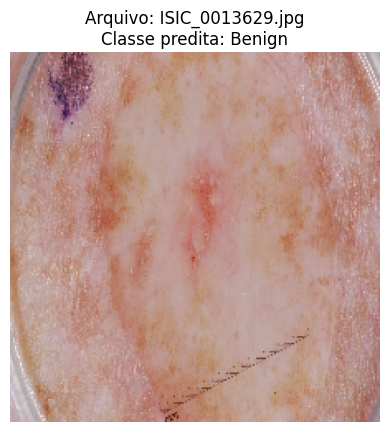

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


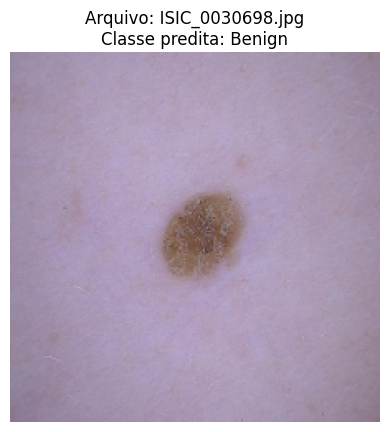

In [32]:
predict_random_image(model_new)
